In [1]:
from gensim.models import word2vec
import MeCab
import numpy as np
import json
import hashlib
from sklearn.cross_decomposition import CCA
from googletrans import Translator
import numpy as np
from keras.layers import Dense,Dropout
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import random
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import np_utils
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
translator = Translator()
mt = MeCab.Tagger('-d /usr/local/lib/mecab/dic/mecab-ipadic-neologd/')
mt.parse('')

'EOS\n'

In [3]:
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
model_doc = Doc2Vec.load("jawiki.doc2vec.dbow300d.model")
model_word = word2vec.Word2Vec.load("wiki_plus.model")

In [4]:
def get_tags(text):
    word = {}
    node = mt.parseToNode(text)
    while node:
        fields = node.feature.split(",")
        if (fields[0] == '名詞' or fields[0] == '動詞' or fields[0] == '形容詞') and node.surface in model_word.wv:
            w = node.surface
            word[w] = word.get(w, 0) + 1
        node = node.next
    return word

def weighted_mean_vec(text):
    v = np.zeros(model_word.vector_size)
    s = 1.0
    for w,weight in get_tags(text).items():
        v += weight * model_word.wv[w]  #Eventクラスeの単語wの個数＊単語wのベクトル
        s += weight
    return v / s

In [5]:
def get_tags_for_doc2vec(text):
    word = []
    node = mt.parseToNode(text)
    while node:
        fields = node.feature.split(",")
        if node.surface in model_doc.wv and node.surface !='':
            w = node.surface
            word.append(w)
        node = node.next
    return word

In [6]:
class Event:
    def __init__(self, id, type, score, desc, links):
        self.id = id
        self.type = type
        self.score = score
        self.desc = desc
        self.tags = get_tags(desc)
        self.links = links
    
    def __str__(self):
        return 'id: {id} type: {type} score: {score} tags: {tags}'.format(id=self.id, type=self.type, score=self.score, tags=str(self.tags))

    def __repr__(self):
        return 'id: {id} type: {type} score: {score} tags: {tags}'.format(id=self.id, type=self.type, score=self.score, tags=str(self.tags))

In [7]:
class Event_doc2vec(Event):
    def __init__(self, id, type, score, desc, links):
        super().__init__(id,type,score,desc,links)
        self.tags = get_tags_for_doc2vec(desc)

In [8]:
# JSON ファイルから event set をロード
def load_events(jsonfile):
    with open(jsonfile) as f:
        df = json.load(f)
    events = {x['id']: Event(x['id'], x['type'], x['score'], x['desc'], x['links']) for x in df} #eventsにidをkeyとしそのオブジェクトをvalueとした辞書を生成
    for k,x in events.items():
        x.links = [events[e] for e in x.links] #Event.linkの中身をidの配列からEventの配列に変更
    return events

In [9]:
# JSON ファイルから event set をロード ver.doc2vec
def load_events_for_doc2vec(jsonfile):
    with open(jsonfile) as f:
        df = json.load(f)
    events = {x['id']: Event_doc2vec(x['id'], x['type'], x['score'], x['desc'], x['links']) for x in df} #eventsにidをkeyとしそのオブジェクトをvalueとした辞書を生成
    for k,x in events.items():
        x.links = [events[e] for e in x.links] #Event.linkの中身をidの配列からEventの配列に変更
    return events

In [10]:
events = load_events('sesaku2.json')
events_doc2vec = load_events_for_doc2vec('sesaku2.json')

In [11]:
import pandas as pd
data = []
labels = []
columns=[]
index=[]
for k1, v1 in events.items():
    if v1.type[-1]=='部品':
        index.append(v1.desc)
for k1, v1 in events.items():
    if v1.type[-1]=='対策':
        if not v1.desc in columns:
            columns.append(v1.desc)
df = pd.DataFrame(index=index, columns=columns)
for k1, v1 in events.items():
    if v1.type[-1]=='部品':
        for k2, v2 in events.items():
            if v2.type[-1] == '対策':
                    if v2 in v1.links:
                        df.at[v1.desc, v2.desc] = 1
                    else:
                        df.at[v1.desc, v2.desc] = 0
df

,前機種の振り返りを実施。目標に対する達成度、課題と次の一手を適用している,会社方針と中・長期計画を基に、商品企画と製品企画を経て、目標を設定している。,社会との調和、社会への貢献実現のビジョンがある,経営責任を明確化,的確な経営判断が９０％の迅速さで下されている,社長を補佐できるキーパーソンが各部門に存在,方針管理は部門別と機能別を組み合わせたマトリックスマネジメントで管理,日常管理が各機能ごとに項目と目標が明確で、管理責任者も設定,管理目標から外れた場合のアクションが取られている,QCDの視点で、目標を設定。関連部品にも目標展開、仕様を決めた後、全体目標をアラインしている。,...,異常有無を全数検査している（外観・異音・振動等）,プランジャ当たり面の検査は、定量化・仕組み化・標準化しているか,インジェクターの色識別（品番との合致）,噴射レベルの抜き取り検査,エンジン性能の検査（トヨタ）,"機能テストは、設計指示の環境条件を満足しているか (燃料,温度,気圧 等)",インジェクターをエンジンに挿入する時の抵抗測定をする,バリ、異物有無を検査している（画像検査等）,機能検査を実施している（電流ｘ噴射量）,リーク検査を実施しているる
エンジン搭載 吸気レゾネーター,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
エンジン搭載 燃料ポンプ 抵抗器アセンブリ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
エンジン搭載 燃料ポンプ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
エンジン搭載 ゴム クッション,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
エンジン搭載 燃料圧力ダンパー,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
エンジン搭載 燃料ポンプ 抵抗カバー,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
エンジン搭載 燃料フィルター,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
エンジン搭載 燃料パイプ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
エンジン搭載 燃料蒸気供給ホース,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
エンジン搭載 燃料ホース クランプ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [12]:
df.shape

(173, 319)

In [13]:
taisaku_vec_word = {}
for i in df:
    taisaku_vec_word[i]=weighted_mean_vec(i)

In [14]:
taisaku_vec_doc = {}
for i in df:
    taisaku_vec_doc[i]=model_doc.infer_vector(get_tags_for_doc2vec(i))

In [15]:
class Label:
    TAISAKU = 1
    NASI = 0

data_word = []
labels_word = []
# data 
for index, row in df.iterrows():#部品
    x1 = weighted_mean_vec(index)
    for i in df:#対策
        x2 =  taisaku_vec_word[i]#対策
        data_word.extend([np.append(x1, x2)])
        if row[i] ==1:
            labels_word.append(Label.TAISAKU)
        else:
            labels_word.append(Label.NASI)

In [16]:
data_doc = []
labels_doc = []
# data 
for index, row in df.iterrows():#部品
    x1 = model_doc.infer_vector(get_tags_for_doc2vec(index))
    for i in df:#対策
        x2 =  taisaku_vec_doc[i]#対策
        data_doc.extend([np.append(x1, x2)])
        if row[i] ==1:
            labels_doc.append(Label.TAISAKU)
        else:
            labels_doc.append(Label.NASI)

In [17]:
def train_data(data,labels):
    index_1 = [i for i, x in enumerate(labels) if x == 1]
    index_0 = [i for i, x in enumerate(labels) if x == 0]
    index_0 = random.sample(index_0, len(index_1))
    data_1 = [data[i] for i in index_1]
    data_0 = [data[i] for i in index_0]
    labels = [Label.TAISAKU]*len(data_1) + [Label.NASI]*len(data_0) 
    data = data_1 + data_0
    data = np.array(data)
    labels = np.array(labels)
    return data, labels

In [18]:
len(data_doc[1])

600

In [19]:
len(data_word[1])

400

In [20]:
data_word2,labels_word2 = train_data(data_word,labels_word)
print(data_word2.shape,labels_word2.shape)

(14606, 400) (14606,)


In [21]:
data_doc2,labels_doc2 = train_data(data_doc,labels_doc)
print(data_doc2.shape,labels_doc2.shape)

(14606, 600) (14606,)


In [22]:
def gakusyu(data,labels):
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size=0.2)
    print('トレーニングデータの1の数    :',y_train.sum())
    print('トレーニングデータ1の割合    :',round(y_train.sum()/x_train.shape[0]*100,1),'%')
    print('テストデータの１の数            :',y_test.sum())
    print('テストデータの1の割合          :',round(y_test.sum()/x_test.shape[0]*100,1),'%')
    # y_train を one-hot 表現にする。
    y_train_one_hot = np_utils.to_categorical(y_train)
    y_test_one_hot = np_utils.to_categorical(y_test)
    # モデルを作成する。
    model = Sequential()
    model.add(Dense(128, activation='relu', input_shape=x_train.shape[1:])) #activation
    #model.add(Dropout(0.2))
    model.add(Dense(128, activation='relu'))
    #model.add(Dropout(0.2))
    model.add(Dense(2, activation='softmax'))

    model.compile(
        optimizer=Adam(lr=0.001), #最適化アルゴリズムの種類.sgd,rmsprop,adam,adagrad,nadam,adadeltaなどある。
        loss='categorical_crossentropy', #損失関数名
        metrics=['accuracy']) #訓練やテストの際にモデルを評価するための評価関数のリスト． 典型的には metrics=['accuracy']を使用する.

    # 学習を実行する。
    result = model.fit(x_train, y_train_one_hot , batch_size=16, epochs=30,validation_data=(x_test, y_test_one_hot )) #epochs 学習回数,batch_size 重みを調整の際に行う平均化のときに使うデータの数（dataの数/batch_size回）×epochs

    # 推論する。
    prob = model.predict(x_test, batch_size=len(x_test))

    # 最も確率が高いのを推定クラスとする。
    y_pred = np.argmax(prob, axis=1)

    # 精度を検証する。
    accuracy = accuracy_score(y_test, y_pred)
    print('accuracy: {:.2%}'.format(accuracy))
    return result, accuracy, model, x_test, y_test_one_hot

# PCA

In [23]:
import numpy as np
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt

In [24]:
def pca_accuracy_word(n):
    pca = PCA(n_components=n)
    pca.fit(data_word)
    data_word_pca = pca.transform(data_word)
    history = {'word_pca':0,'word_count':0}
    word_result = []
    for i in range(10):
        data_word2, labels_word2= train_data(data_word_pca,labels_word)
        result, accuracy, model, x_test, y_test = gakusyu(data_word2, labels_word2)
        history['word_pca'] = history['word_pca'] + accuracy
        history['word_count'] += 1
        word_result.append(result)
    word_result_all = {'accuracy':[0]*30,'val_accuracy':[0]*30}
    for k,v in word_result_all.items():
        for i in range(30):
            for j in word_result:
                v[i] += j.history[k][i]
            v[i] /= 10
    return word_result_all

def accuracy_plt(word_result):
    plt.plot(range(1, 30+1),word_result['accuracy'] , label="training")
    plt.plot(range(1, 30+1), word_result['val_accuracy'], label="validation")
    plt.xlabel('学習回数')
    plt.ylabel('正解率')
    plt.legend()
    plt.show()

In [25]:
word4_result = pca_accuracy_word(4)
word40_result = pca_accuracy_word(40)
word80_result = pca_accuracy_word(80)
word160_result = pca_accuracy_word(160)

トレーニングデータの1の数    : 5845
トレーニングデータ1の割合    : 50.0 %
テストデータの１の数            : 1458
テストデータの1の割合          : 49.9 %
Epoch 1/30
731/731 [==============================] - 1s 806us/step - loss: 0.5987 - accuracy: 0.6781 - val_loss: 0.5983 - val_accuracy: 0.6899
Epoch 2/30
731/731 [==============================] - 0s 658us/step - loss: 0.5500 - accuracy: 0.7212 - val_loss: 0.5327 - val_accuracy: 0.7402
Epoch 3/30
731/731 [==============================] - 0s 643us/step - loss: 0.5236 - accuracy: 0.7350 - val_loss: 0.5171 - val_accuracy: 0.7358
Epoch 4/30
731/731 [==============================] - 0s 642us/step - loss: 0.4953 - accuracy: 0.7557 - val_loss: 0.4875 - val_accuracy: 0.7457
Epoch 5/30
731/731 [==============================] - 0s 646us/step - loss: 0.4669 - accuracy: 0.7770 - val_loss: 0.4491 - val_accuracy: 0.7858
Epoch 6/30
731/731 [==============================] - 1s 730us/step - loss: 0.4391 - accuracy: 0.7941 - val_loss: 0.4341 - val_accuracy: 0.7912
Epoch 7/30
731/731 [=======

731/731 [==============================] - 0s 672us/step - loss: 0.2477 - accuracy: 0.8828 - val_loss: 0.2755 - val_accuracy: 0.8741
Epoch 27/30
731/731 [==============================] - 0s 640us/step - loss: 0.2423 - accuracy: 0.8854 - val_loss: 0.2737 - val_accuracy: 0.8826
Epoch 28/30
731/731 [==============================] - 0s 664us/step - loss: 0.2438 - accuracy: 0.8852 - val_loss: 0.2860 - val_accuracy: 0.8658
Epoch 29/30
731/731 [==============================] - 0s 630us/step - loss: 0.2428 - accuracy: 0.8882 - val_loss: 0.2784 - val_accuracy: 0.8717
Epoch 30/30
731/731 [==============================] - 0s 666us/step - loss: 0.2390 - accuracy: 0.8884 - val_loss: 0.2825 - val_accuracy: 0.8669
accuracy: 86.69%
トレーニングデータの1の数    : 5858
トレーニングデータ1の割合    : 50.1 %
テストデータの１の数            : 1445
テストデータの1の割合          : 49.5 %
Epoch 1/30
731/731 [==============================] - 1s 800us/step - loss: 0.6029 - accuracy: 0.6730 - val_loss: 0.5767 - val_accuracy: 0.6817
Epoch 2/30
731/73

Epoch 21/30
731/731 [==============================] - 0s 657us/step - loss: 0.2630 - accuracy: 0.8835 - val_loss: 0.2922 - val_accuracy: 0.8754
Epoch 22/30
731/731 [==============================] - 0s 641us/step - loss: 0.2606 - accuracy: 0.8825 - val_loss: 0.2973 - val_accuracy: 0.8713
Epoch 23/30
731/731 [==============================] - 0s 649us/step - loss: 0.2567 - accuracy: 0.8818 - val_loss: 0.2789 - val_accuracy: 0.8727
Epoch 24/30
731/731 [==============================] - 0s 666us/step - loss: 0.2532 - accuracy: 0.8836 - val_loss: 0.2841 - val_accuracy: 0.8713
Epoch 25/30
731/731 [==============================] - 0s 652us/step - loss: 0.2532 - accuracy: 0.8857 - val_loss: 0.2732 - val_accuracy: 0.8720
Epoch 26/30
731/731 [==============================] - 0s 648us/step - loss: 0.2524 - accuracy: 0.8845 - val_loss: 0.2748 - val_accuracy: 0.8741
Epoch 27/30
731/731 [==============================] - 0s 650us/step - loss: 0.2465 - accuracy: 0.8874 - val_loss: 0.2787 - val_ac

Epoch 11/30
731/731 [==============================] - 0s 630us/step - loss: 0.3483 - accuracy: 0.8505 - val_loss: 0.3332 - val_accuracy: 0.8597
Epoch 12/30
731/731 [==============================] - 0s 628us/step - loss: 0.3362 - accuracy: 0.8544 - val_loss: 0.3386 - val_accuracy: 0.8617
Epoch 13/30
731/731 [==============================] - 0s 626us/step - loss: 0.3224 - accuracy: 0.8639 - val_loss: 0.3257 - val_accuracy: 0.8768
Epoch 14/30
731/731 [==============================] - 0s 627us/step - loss: 0.3162 - accuracy: 0.8681 - val_loss: 0.3146 - val_accuracy: 0.8604
Epoch 15/30
731/731 [==============================] - 0s 624us/step - loss: 0.3023 - accuracy: 0.8734 - val_loss: 0.3183 - val_accuracy: 0.8871
Epoch 16/30
731/731 [==============================] - 0s 624us/step - loss: 0.2968 - accuracy: 0.8738 - val_loss: 0.3056 - val_accuracy: 0.8710
Epoch 17/30
731/731 [==============================] - 1s 732us/step - loss: 0.2911 - accuracy: 0.8762 - val_loss: 0.2933 - val_ac

accuracy: 88.71%
トレーニングデータの1の数    : 5846
トレーニングデータ1の割合    : 50.0 %
テストデータの１の数            : 1457
テストデータの1の割合          : 49.9 %
Epoch 1/30
731/731 [==============================] - 1s 780us/step - loss: 0.5975 - accuracy: 0.6814 - val_loss: 0.5677 - val_accuracy: 0.6913
Epoch 2/30
731/731 [==============================] - 0s 634us/step - loss: 0.5544 - accuracy: 0.7142 - val_loss: 0.5684 - val_accuracy: 0.7375
Epoch 3/30
731/731 [==============================] - 0s 656us/step - loss: 0.5278 - accuracy: 0.7322 - val_loss: 0.5044 - val_accuracy: 0.7567
Epoch 4/30
731/731 [==============================] - 0s 656us/step - loss: 0.4984 - accuracy: 0.7567 - val_loss: 0.4848 - val_accuracy: 0.7526
Epoch 5/30
731/731 [==============================] - 0s 659us/step - loss: 0.4682 - accuracy: 0.7741 - val_loss: 0.4460 - val_accuracy: 0.8268
Epoch 6/30
731/731 [==============================] - 0s 654us/step - loss: 0.4391 - accuracy: 0.7966 - val_loss: 0.4012 - val_accuracy: 0.8251
Epoch 7/30

Epoch 21/30
731/731 [==============================] - 0s 643us/step - loss: 0.2698 - accuracy: 0.8807 - val_loss: 0.3044 - val_accuracy: 0.8802
Epoch 22/30
731/731 [==============================] - 0s 641us/step - loss: 0.2640 - accuracy: 0.8790 - val_loss: 0.2976 - val_accuracy: 0.8676
Epoch 23/30
731/731 [==============================] - 0s 634us/step - loss: 0.2639 - accuracy: 0.8804 - val_loss: 0.3104 - val_accuracy: 0.8580
Epoch 24/30
731/731 [==============================] - 0s 637us/step - loss: 0.2617 - accuracy: 0.8805 - val_loss: 0.2842 - val_accuracy: 0.8768
Epoch 25/30
731/731 [==============================] - 0s 637us/step - loss: 0.2569 - accuracy: 0.8798 - val_loss: 0.2958 - val_accuracy: 0.8645
Epoch 26/30
731/731 [==============================] - 0s 634us/step - loss: 0.2569 - accuracy: 0.8827 - val_loss: 0.3089 - val_accuracy: 0.8556
Epoch 27/30
731/731 [==============================] - 0s 635us/step - loss: 0.2563 - accuracy: 0.8839 - val_loss: 0.2674 - val_ac

731/731 [==============================] - 0s 644us/step - loss: 0.1371 - accuracy: 0.9511 - val_loss: 0.1793 - val_accuracy: 0.9357
Epoch 6/30
731/731 [==============================] - 0s 642us/step - loss: 0.1282 - accuracy: 0.9536 - val_loss: 0.1802 - val_accuracy: 0.9326
Epoch 7/30
731/731 [==============================] - 0s 643us/step - loss: 0.1192 - accuracy: 0.9544 - val_loss: 0.1646 - val_accuracy: 0.9446
Epoch 8/30
731/731 [==============================] - 0s 645us/step - loss: 0.1106 - accuracy: 0.9580 - val_loss: 0.1596 - val_accuracy: 0.9449
Epoch 9/30
731/731 [==============================] - 0s 642us/step - loss: 0.1055 - accuracy: 0.9614 - val_loss: 0.1636 - val_accuracy: 0.9360
Epoch 10/30
731/731 [==============================] - 0s 647us/step - loss: 0.0964 - accuracy: 0.9629 - val_loss: 0.1659 - val_accuracy: 0.9466
Epoch 11/30
731/731 [==============================] - 0s 643us/step - loss: 0.0918 - accuracy: 0.9653 - val_loss: 0.1603 - val_accuracy: 0.9476
E

731/731 [==============================] - 0s 657us/step - loss: 0.0480 - accuracy: 0.9808 - val_loss: 0.1439 - val_accuracy: 0.9603
Epoch 26/30
731/731 [==============================] - 0s 651us/step - loss: 0.0435 - accuracy: 0.9837 - val_loss: 0.1411 - val_accuracy: 0.9569
Epoch 27/30
731/731 [==============================] - 0s 645us/step - loss: 0.0423 - accuracy: 0.9831 - val_loss: 0.1411 - val_accuracy: 0.9613
Epoch 28/30
731/731 [==============================] - 0s 645us/step - loss: 0.0406 - accuracy: 0.9847 - val_loss: 0.1353 - val_accuracy: 0.9593
Epoch 29/30
731/731 [==============================] - 0s 645us/step - loss: 0.0417 - accuracy: 0.9830 - val_loss: 0.1426 - val_accuracy: 0.9637
Epoch 30/30
731/731 [==============================] - 0s 644us/step - loss: 0.0391 - accuracy: 0.9853 - val_loss: 0.1469 - val_accuracy: 0.9569
accuracy: 95.69%
トレーニングデータの1の数    : 5834
トレーニングデータ1の割合    : 49.9 %
テストデータの１の数            : 1469
テストデータの1の割合          : 50.3 %
Epoch 1/30
731/7

731/731 [==============================] - 0s 644us/step - loss: 0.0984 - accuracy: 0.9611 - val_loss: 0.1630 - val_accuracy: 0.9432
Epoch 10/30
731/731 [==============================] - 0s 641us/step - loss: 0.0909 - accuracy: 0.9667 - val_loss: 0.1539 - val_accuracy: 0.9487
Epoch 11/30
731/731 [==============================] - 0s 641us/step - loss: 0.0848 - accuracy: 0.9684 - val_loss: 0.1600 - val_accuracy: 0.9493
Epoch 12/30
731/731 [==============================] - 0s 643us/step - loss: 0.0822 - accuracy: 0.9680 - val_loss: 0.1400 - val_accuracy: 0.9569
Epoch 13/30
731/731 [==============================] - 0s 644us/step - loss: 0.0740 - accuracy: 0.9707 - val_loss: 0.1440 - val_accuracy: 0.9497
Epoch 14/30
731/731 [==============================] - 0s 638us/step - loss: 0.0710 - accuracy: 0.9739 - val_loss: 0.1437 - val_accuracy: 0.9582
Epoch 15/30
731/731 [==============================] - 0s 642us/step - loss: 0.0692 - accuracy: 0.9726 - val_loss: 0.1505 - val_accuracy: 0.95

731/731 [==============================] - 0s 641us/step - loss: 0.0447 - accuracy: 0.9825 - val_loss: 0.2082 - val_accuracy: 0.9521
Epoch 30/30
731/731 [==============================] - 0s 639us/step - loss: 0.0398 - accuracy: 0.9834 - val_loss: 0.2027 - val_accuracy: 0.9456
accuracy: 94.56%
トレーニングデータの1の数    : 5826
トレーニングデータ1の割合    : 49.9 %
テストデータの１の数            : 1477
テストデータの1の割合          : 50.5 %
Epoch 1/30
731/731 [==============================] - 1s 754us/step - loss: 0.3269 - accuracy: 0.8607 - val_loss: 0.2366 - val_accuracy: 0.9131
Epoch 2/30
731/731 [==============================] - 0s 652us/step - loss: 0.1853 - accuracy: 0.9297 - val_loss: 0.1779 - val_accuracy: 0.9298
Epoch 3/30
731/731 [==============================] - 0s 644us/step - loss: 0.1571 - accuracy: 0.9440 - val_loss: 0.1751 - val_accuracy: 0.9302
Epoch 4/30
731/731 [==============================] - 0s 648us/step - loss: 0.1430 - accuracy: 0.9491 - val_loss: 0.1648 - val_accuracy: 0.9394
Epoch 5/30
731/731 [

731/731 [==============================] - 0s 646us/step - loss: 0.0809 - accuracy: 0.9693 - val_loss: 0.1517 - val_accuracy: 0.9487
Epoch 14/30
731/731 [==============================] - 0s 645us/step - loss: 0.0778 - accuracy: 0.9712 - val_loss: 0.1369 - val_accuracy: 0.9565
Epoch 15/30
731/731 [==============================] - 0s 669us/step - loss: 0.0666 - accuracy: 0.9748 - val_loss: 0.1581 - val_accuracy: 0.9500
Epoch 18/30
731/731 [==============================] - 1s 863us/step - loss: 0.0646 - accuracy: 0.9748 - val_loss: 0.1449 - val_accuracy: 0.9493
Epoch 19/30
731/731 [==============================] - 0s 645us/step - loss: 0.0644 - accuracy: 0.9749 - val_loss: 0.1412 - val_accuracy: 0.9545
Epoch 20/30
731/731 [==============================] - 0s 653us/step - loss: 0.0621 - accuracy: 0.9751 - val_loss: 0.1553 - val_accuracy: 0.9511
Epoch 21/30
731/731 [==============================] - 0s 639us/step - loss: 0.0579 - accuracy: 0.9753 - val_loss: 0.1603 - val_accuracy: 0.95

accuracy: 95.14%
トレーニングデータの1の数    : 5834
トレーニングデータ1の割合    : 49.9 %
テストデータの１の数            : 1469
テストデータの1の割合          : 50.3 %
Epoch 1/30
731/731 [==============================] - 1s 930us/step - loss: 0.3341 - accuracy: 0.8577 - val_loss: 0.2570 - val_accuracy: 0.9035
Epoch 2/30
731/731 [==============================] - 0s 676us/step - loss: 0.1989 - accuracy: 0.9262 - val_loss: 0.2051 - val_accuracy: 0.9298
Epoch 3/30
731/731 [==============================] - 1s 704us/step - loss: 0.1671 - accuracy: 0.9353 - val_loss: 0.1824 - val_accuracy: 0.9394
Epoch 4/30
731/731 [==============================] - 1s 695us/step - loss: 0.1505 - accuracy: 0.9435 - val_loss: 0.1822 - val_accuracy: 0.9333
Epoch 5/30
731/731 [==============================] - 1s 732us/step - loss: 0.1401 - accuracy: 0.9456 - val_loss: 0.1633 - val_accuracy: 0.9377
Epoch 6/30
731/731 [==============================] - 1s 733us/step - loss: 0.1300 - accuracy: 0.9512 - val_loss: 0.1726 - val_accuracy: 0.9408
Epoch 7/30

731/731 [==============================] - 0s 668us/step - loss: 0.0571 - accuracy: 0.9784 - val_loss: 0.1567 - val_accuracy: 0.9531
Epoch 21/30
731/731 [==============================] - 0s 649us/step - loss: 0.0547 - accuracy: 0.9774 - val_loss: 0.1715 - val_accuracy: 0.9473
Epoch 22/30
731/731 [==============================] - 0s 646us/step - loss: 0.0565 - accuracy: 0.9782 - val_loss: 0.1746 - val_accuracy: 0.9535
Epoch 23/30
731/731 [==============================] - 0s 651us/step - loss: 0.0531 - accuracy: 0.9778 - val_loss: 0.1584 - val_accuracy: 0.9514
Epoch 24/30
731/731 [==============================] - 0s 651us/step - loss: 0.0540 - accuracy: 0.9795 - val_loss: 0.1634 - val_accuracy: 0.9521
Epoch 25/30
731/731 [==============================] - 0s 650us/step - loss: 0.0506 - accuracy: 0.9803 - val_loss: 0.1658 - val_accuracy: 0.9524
Epoch 26/30
731/731 [==============================] - 0s 654us/step - loss: 0.0487 - accuracy: 0.9807 - val_loss: 0.1674 - val_accuracy: 0.95

731/731 [==============================] - 0s 669us/step - loss: 0.1176 - accuracy: 0.9577 - val_loss: 0.1465 - val_accuracy: 0.9442
Epoch 5/30
731/731 [==============================] - 0s 669us/step - loss: 0.1038 - accuracy: 0.9629 - val_loss: 0.1301 - val_accuracy: 0.9545
Epoch 6/30
731/731 [==============================] - 0s 678us/step - loss: 0.0941 - accuracy: 0.9653 - val_loss: 0.1435 - val_accuracy: 0.9497
Epoch 7/30
731/731 [==============================] - 0s 682us/step - loss: 0.0846 - accuracy: 0.9685 - val_loss: 0.1364 - val_accuracy: 0.9565
Epoch 8/30
731/731 [==============================] - 0s 681us/step - loss: 0.0798 - accuracy: 0.9687 - val_loss: 0.1464 - val_accuracy: 0.9500
Epoch 9/30
731/731 [==============================] - 0s 683us/step - loss: 0.0749 - accuracy: 0.9713 - val_loss: 0.1317 - val_accuracy: 0.9559
Epoch 10/30
731/731 [==============================] - 1s 689us/step - loss: 0.0674 - accuracy: 0.9733 - val_loss: 0.1203 - val_accuracy: 0.9559
Ep

731/731 [==============================] - 1s 708us/step - loss: 0.0296 - accuracy: 0.9872 - val_loss: 0.1154 - val_accuracy: 0.9692
Epoch 25/30
731/731 [==============================] - 1s 718us/step - loss: 0.0285 - accuracy: 0.9877 - val_loss: 0.1239 - val_accuracy: 0.9689
Epoch 26/30
731/731 [==============================] - 1s 753us/step - loss: 0.0334 - accuracy: 0.9864 - val_loss: 0.1368 - val_accuracy: 0.9658
Epoch 27/30
731/731 [==============================] - 1s 729us/step - loss: 0.0381 - accuracy: 0.9849 - val_loss: 0.1085 - val_accuracy: 0.9716
Epoch 28/30
731/731 [==============================] - 1s 722us/step - loss: 0.0258 - accuracy: 0.9890 - val_loss: 0.1065 - val_accuracy: 0.9699
Epoch 29/30
731/731 [==============================] - 1s 689us/step - loss: 0.0301 - accuracy: 0.9883 - val_loss: 0.1093 - val_accuracy: 0.9706
Epoch 30/30
731/731 [==============================] - 0s 677us/step - loss: 0.0261 - accuracy: 0.9896 - val_loss: 0.1080 - val_accuracy: 0.96

731/731 [==============================] - 1s 741us/step - loss: 0.0756 - accuracy: 0.9703 - val_loss: 0.1477 - val_accuracy: 0.9466
Epoch 9/30
731/731 [==============================] - 1s 693us/step - loss: 0.0668 - accuracy: 0.9736 - val_loss: 0.1753 - val_accuracy: 0.9449
Epoch 10/30
731/731 [==============================] - 0s 658us/step - loss: 0.0626 - accuracy: 0.9746 - val_loss: 0.1621 - val_accuracy: 0.9497
Epoch 11/30
731/731 [==============================] - 0s 672us/step - loss: 0.0588 - accuracy: 0.9780 - val_loss: 0.1489 - val_accuracy: 0.9500
Epoch 12/30
731/731 [==============================] - 0s 678us/step - loss: 0.0513 - accuracy: 0.9791 - val_loss: 0.1522 - val_accuracy: 0.9497
Epoch 13/30
731/731 [==============================] - 0s 663us/step - loss: 0.0485 - accuracy: 0.9799 - val_loss: 0.1358 - val_accuracy: 0.9565
Epoch 14/30
731/731 [==============================] - 0s 659us/step - loss: 0.0444 - accuracy: 0.9833 - val_loss: 0.1500 - val_accuracy: 0.949

731/731 [==============================] - 0s 674us/step - loss: 0.0287 - accuracy: 0.9883 - val_loss: 0.1603 - val_accuracy: 0.9627
Epoch 29/30
731/731 [==============================] - 0s 663us/step - loss: 0.0252 - accuracy: 0.9892 - val_loss: 0.1752 - val_accuracy: 0.9648
Epoch 30/30
731/731 [==============================] - 0s 660us/step - loss: 0.0380 - accuracy: 0.9866 - val_loss: 0.1640 - val_accuracy: 0.9651
accuracy: 96.51%
トレーニングデータの1の数    : 5837
トレーニングデータ1の割合    : 50.0 %
テストデータの１の数            : 1466
テストデータの1の割合          : 50.2 %
Epoch 1/30
731/731 [==============================] - 1s 773us/step - loss: 0.2784 - accuracy: 0.8881 - val_loss: 0.1815 - val_accuracy: 0.9387
Epoch 2/30
731/731 [==============================] - 0s 661us/step - loss: 0.1569 - accuracy: 0.9440 - val_loss: 0.1595 - val_accuracy: 0.9408
Epoch 3/30
731/731 [==============================] - 0s 665us/step - loss: 0.1273 - accuracy: 0.9540 - val_loss: 0.1309 - val_accuracy: 0.9582
Epoch 4/30
731/731 

731/731 [==============================] - 1s 797us/step - loss: 0.0532 - accuracy: 0.9778 - val_loss: 0.1456 - val_accuracy: 0.9572
Epoch 13/30
731/731 [==============================] - 1s 766us/step - loss: 0.0521 - accuracy: 0.9790 - val_loss: 0.1483 - val_accuracy: 0.9531
Epoch 14/30
731/731 [==============================] - 1s 830us/step - loss: 0.0461 - accuracy: 0.9813 - val_loss: 0.1393 - val_accuracy: 0.9589
Epoch 15/30
731/731 [==============================] - 1s 784us/step - loss: 0.0422 - accuracy: 0.9813 - val_loss: 0.1403 - val_accuracy: 0.9582
Epoch 16/30
731/731 [==============================] - 1s 810us/step - loss: 0.0393 - accuracy: 0.9848 - val_loss: 0.1323 - val_accuracy: 0.9603
Epoch 17/30
731/731 [==============================] - 1s 775us/step - loss: 0.0465 - accuracy: 0.9818 - val_loss: 0.2015 - val_accuracy: 0.9480
Epoch 18/30
731/731 [==============================] - 1s 778us/step - loss: 0.0345 - accuracy: 0.9851 - val_loss: 0.1413 - val_accuracy: 0.96

accuracy: 97.09%
トレーニングデータの1の数    : 5844
トレーニングデータ1の割合    : 50.0 %
テストデータの１の数            : 1459
テストデータの1の割合          : 49.9 %
Epoch 1/30
731/731 [==============================] - 1s 881us/step - loss: 0.2802 - accuracy: 0.8846 - val_loss: 0.2200 - val_accuracy: 0.9240
Epoch 2/30
731/731 [==============================] - 1s 747us/step - loss: 0.1585 - accuracy: 0.9426 - val_loss: 0.1963 - val_accuracy: 0.9336
Epoch 3/30
731/731 [==============================] - 1s 733us/step - loss: 0.1309 - accuracy: 0.9547 - val_loss: 0.1618 - val_accuracy: 0.9473
Epoch 4/30
731/731 [==============================] - 1s 754us/step - loss: 0.1146 - accuracy: 0.9603 - val_loss: 0.1520 - val_accuracy: 0.9487
Epoch 5/30
731/731 [==============================] - 1s 752us/step - loss: 0.1010 - accuracy: 0.9640 - val_loss: 0.1505 - val_accuracy: 0.9538
Epoch 6/30
731/731 [==============================] - 1s 786us/step - loss: 0.0892 - accuracy: 0.9663 - val_loss: 0.1494 - val_accuracy: 0.9545
Epoch 7/30

Epoch 21/30
731/731 [==============================] - 1s 688us/step - loss: 0.0327 - accuracy: 0.9877 - val_loss: 0.1204 - val_accuracy: 0.9726
Epoch 22/30
731/731 [==============================] - 0s 682us/step - loss: 0.0240 - accuracy: 0.9899 - val_loss: 0.1045 - val_accuracy: 0.9778
Epoch 23/30
731/731 [==============================] - 1s 686us/step - loss: 0.0210 - accuracy: 0.9902 - val_loss: 0.1130 - val_accuracy: 0.9736
Epoch 24/30
731/731 [==============================] - 0s 682us/step - loss: 0.0235 - accuracy: 0.9902 - val_loss: 0.1030 - val_accuracy: 0.9747
Epoch 25/30
731/731 [==============================] - 0s 682us/step - loss: 0.0200 - accuracy: 0.9913 - val_loss: 0.1109 - val_accuracy: 0.9771
Epoch 26/30
731/731 [==============================] - 0s 678us/step - loss: 0.0190 - accuracy: 0.9909 - val_loss: 0.1069 - val_accuracy: 0.9795
Epoch 27/30
731/731 [==============================] - 1s 684us/step - loss: 0.0252 - accuracy: 0.9891 - val_loss: 0.1500 - val_ac

731/731 [==============================] - 0s 681us/step - loss: 0.0720 - accuracy: 0.9728 - val_loss: 0.1202 - val_accuracy: 0.9541
Epoch 6/30
731/731 [==============================] - 0s 679us/step - loss: 0.0601 - accuracy: 0.9770 - val_loss: 0.1190 - val_accuracy: 0.9593
Epoch 7/30
731/731 [==============================] - 0s 682us/step - loss: 0.0527 - accuracy: 0.9778 - val_loss: 0.1163 - val_accuracy: 0.9654
Epoch 8/30
731/731 [==============================] - 1s 685us/step - loss: 0.0529 - accuracy: 0.9797 - val_loss: 0.1062 - val_accuracy: 0.9668
Epoch 9/30
731/731 [==============================] - 0s 682us/step - loss: 0.0388 - accuracy: 0.9839 - val_loss: 0.1190 - val_accuracy: 0.9685
Epoch 10/30
731/731 [==============================] - 0s 681us/step - loss: 0.0365 - accuracy: 0.9849 - val_loss: 0.1183 - val_accuracy: 0.9630
Epoch 11/30
731/731 [==============================] - 0s 678us/step - loss: 0.0323 - accuracy: 0.9872 - val_loss: 0.1178 - val_accuracy: 0.9716
E

731/731 [==============================] - 0s 674us/step - loss: 0.0165 - accuracy: 0.9926 - val_loss: 0.0505 - val_accuracy: 0.9836
Epoch 26/30
731/731 [==============================] - 0s 680us/step - loss: 0.0155 - accuracy: 0.9932 - val_loss: 0.0545 - val_accuracy: 0.9867
Epoch 27/30
731/731 [==============================] - 0s 683us/step - loss: 0.0151 - accuracy: 0.9925 - val_loss: 0.0786 - val_accuracy: 0.9795
Epoch 28/30
731/731 [==============================] - 1s 684us/step - loss: 0.0317 - accuracy: 0.9890 - val_loss: 0.0630 - val_accuracy: 0.9822
Epoch 29/30
731/731 [==============================] - 0s 678us/step - loss: 0.0182 - accuracy: 0.9919 - val_loss: 0.0644 - val_accuracy: 0.9805
Epoch 30/30
731/731 [==============================] - 1s 737us/step - loss: 0.0161 - accuracy: 0.9926 - val_loss: 0.0863 - val_accuracy: 0.9778
accuracy: 97.78%
トレーニングデータの1の数    : 5825
トレーニングデータ1の割合    : 49.9 %
テストデータの１の数            : 1478
テストデータの1の割合          : 50.6 %
Epoch 1/30
731/7

731/731 [==============================] - 0s 677us/step - loss: 0.0378 - accuracy: 0.9855 - val_loss: 0.0733 - val_accuracy: 0.9713
Epoch 10/30
731/731 [==============================] - 0s 668us/step - loss: 0.0352 - accuracy: 0.9865 - val_loss: 0.0726 - val_accuracy: 0.9754
Epoch 11/30
731/731 [==============================] - 0s 668us/step - loss: 0.0356 - accuracy: 0.9875 - val_loss: 0.0948 - val_accuracy: 0.9692
Epoch 12/30
731/731 [==============================] - 0s 672us/step - loss: 0.0509 - accuracy: 0.9852 - val_loss: 0.0644 - val_accuracy: 0.9798
Epoch 13/30
731/731 [==============================] - 1s 759us/step - loss: 0.0262 - accuracy: 0.9897 - val_loss: 0.0710 - val_accuracy: 0.9747
Epoch 14/30
731/731 [==============================] - 0s 682us/step - loss: 0.0234 - accuracy: 0.9902 - val_loss: 0.0660 - val_accuracy: 0.9798
Epoch 15/30
731/731 [==============================] - 0s 671us/step - loss: 0.0326 - accuracy: 0.9881 - val_loss: 0.0895 - val_accuracy: 0.97

731/731 [==============================] - 0s 679us/step - loss: 0.0275 - accuracy: 0.9878 - val_loss: 0.0924 - val_accuracy: 0.9819
Epoch 30/30
731/731 [==============================] - 0s 671us/step - loss: 0.0217 - accuracy: 0.9904 - val_loss: 0.1077 - val_accuracy: 0.9778
accuracy: 97.78%
トレーニングデータの1の数    : 5817
トレーニングデータ1の割合    : 49.8 %
テストデータの１の数            : 1486
テストデータの1の割合          : 50.9 %
Epoch 1/30
731/731 [==============================] - 1s 779us/step - loss: 0.2459 - accuracy: 0.9022 - val_loss: 0.1690 - val_accuracy: 0.9449
Epoch 2/30
731/731 [==============================] - 0s 670us/step - loss: 0.1305 - accuracy: 0.9563 - val_loss: 0.1498 - val_accuracy: 0.9446
Epoch 3/30
731/731 [==============================] - 0s 671us/step - loss: 0.1011 - accuracy: 0.9650 - val_loss: 0.1143 - val_accuracy: 0.9634
Epoch 4/30
731/731 [==============================] - 0s 672us/step - loss: 0.0808 - accuracy: 0.9714 - val_loss: 0.1122 - val_accuracy: 0.9617
Epoch 5/30
731/731 [

731/731 [==============================] - 1s 685us/step - loss: 0.0291 - accuracy: 0.9887 - val_loss: 0.0529 - val_accuracy: 0.9795
Epoch 14/30
731/731 [==============================] - 1s 701us/step - loss: 0.0259 - accuracy: 0.9891 - val_loss: 0.0605 - val_accuracy: 0.9774
Epoch 15/30
731/731 [==============================] - 1s 722us/step - loss: 0.0384 - accuracy: 0.9855 - val_loss: 0.0687 - val_accuracy: 0.9764
Epoch 16/30
731/731 [==============================] - 1s 714us/step - loss: 0.0274 - accuracy: 0.9903 - val_loss: 0.0569 - val_accuracy: 0.9798
Epoch 17/30
731/731 [==============================] - 1s 726us/step - loss: 0.0209 - accuracy: 0.9912 - val_loss: 0.0638 - val_accuracy: 0.9778
Epoch 18/30
731/731 [==============================] - 1s 722us/step - loss: 0.0221 - accuracy: 0.9909 - val_loss: 0.0585 - val_accuracy: 0.9815
Epoch 19/30
731/731 [==============================] - 1s 725us/step - loss: 0.0223 - accuracy: 0.9910 - val_loss: 0.0583 - val_accuracy: 0.98

accuracy: 97.91%


/Users/wsiny/.pyenv/versions/3.8.2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 23398 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wsiny/.pyenv/versions/3.8.2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 32722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wsiny/.pyenv/versions/3.8.2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 22238 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wsiny/.pyenv/versions/3.8.2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 25968 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wsiny/.pyenv/versions/3.8.2/lib/python3.8/site-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 27491 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/wsiny/.pyenv/versi

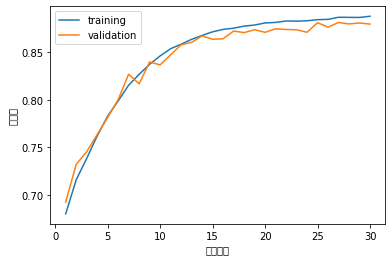

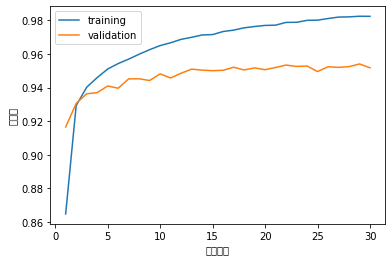

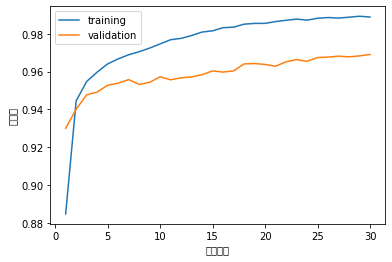

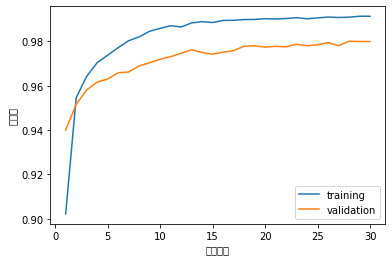

In [31]:
accuracy_plt(word4_result)
accuracy_plt(word40_result)
accuracy_plt(word80_result)
accuracy_plt(word160_result)

#  クラスタリング

In [33]:
from matplotlib import pyplot as plt
from sklearn import datasets, preprocessing
from sklearn.cluster import KMeans
import numpy as np 
import pandas as pd
pred = KMeans(n_clusters=5).fit_predict(data_word)
pred

array([3, 3, 3, ..., 4, 4, 4], dtype=int32)

In [34]:
clustering_data = {0:[], 1:[], 2:[],3:[],4:[]}
clustering_label = {0:[],1:[],2:[],3:[],4:[]}
for i, x in enumerate(pred):
    clustering_data[x].append(data_word[i])
    clustering_label[x].append(labels_word[i])

In [35]:
data_word2, labels_word2= train_data(data_word,labels_word)
result, accuracy, model, x_test, y_test = gakusyu(data_word2, labels_word2)

トレーニングデータの1の数    : 5819
トレーニングデータ1の割合    : 49.8 %
テストデータの１の数            : 1484
テストデータの1の割合          : 50.8 %
Epoch 1/30
731/731 [==============================] - 1s 860us/step - loss: 0.3108 - accuracy: 0.8671 - val_loss: 0.2574 - val_accuracy: 0.9001
Epoch 2/30
731/731 [==============================] - 1s 744us/step - loss: 0.1698 - accuracy: 0.9374 - val_loss: 0.1946 - val_accuracy: 0.9339
Epoch 3/30
731/731 [==============================] - 1s 737us/step - loss: 0.1409 - accuracy: 0.9502 - val_loss: 0.1630 - val_accuracy: 0.9524
Epoch 4/30
731/731 [==============================] - 1s 732us/step - loss: 0.1145 - accuracy: 0.9608 - val_loss: 0.1638 - val_accuracy: 0.9428
Epoch 5/30
731/731 [==============================] - 1s 733us/step - loss: 0.1040 - accuracy: 0.9654 - val_loss: 0.1354 - val_accuracy: 0.9569
Epoch 6/30
731/731 [==============================] - 1s 735us/step - loss: 0.0905 - accuracy: 0.9688 - val_loss: 0.1240 - val_accuracy: 0.9562
Epoch 7/30
731/731 [=======

In [36]:
def clustering_accuracy(data,label):
    data_word2,labels_word2 =  np.array(data),np.array(label)
    #data_word_one_hot = np_utils.to_categorical(data_word2)
    prob = model.predict(data_word2, batch_size=len(data_word2))
    y_pred = np.argmax(prob, axis=1)
    # 精度を検証する。
    accuracy = accuracy_score(labels_word2, y_pred)
    print('accuracy: {:.2%}'.format(accuracy))

In [37]:
clustering_accuracy(clustering_data[0] ,clustering_label[0])
clustering_accuracy(clustering_data[1] ,clustering_label[1])
clustering_accuracy(clustering_data[2] ,clustering_label[2])
clustering_accuracy(clustering_data[3] ,clustering_label[3])
clustering_accuracy(clustering_data[4] ,clustering_label[4])

accuracy: 96.20%
accuracy: 97.59%
accuracy: 99.09%
accuracy: 98.37%
accuracy: 98.11%
